# Parameters Estimation During JUICE's Ganymede Orbital Phase

## Objectives
With this example, you will learn **how to simulate and solve a relevant estimation problem using the `JUICE`'s spacecraft during one of its two Ganymede Circular Orbit Phases**. `JUICE` will make detailed observations of JUPITER and its large ocean-bearing moons – Ganymede, Callisto and Europa – with a suite of remote sensing, geophysical and in situ instruments. Range and Doppler measurements of `JUICE` taken from Earth will improve our knowledge of the Jovian system properties and dynamics. 

This example highlights the basic steps of setting up an orbit estimation routine. In particular, we will focus on how to set up and perform the full estimation of the spacecraft's state and Ganymede's gravitational parameter and spherical harmonics coefficients.

As you will see, we will use a *multi-arc strategy* to simulate and propagate `JUICE`'s orbit. Further, we will highlight all relevant features of modelling a tracking station on Earth. Using this station, we will simulate a tracking routine of the spacecraft using a series of one- and -way doppler measurement every 180 seconds. To assure an uninterrupted line-of-sight between the station and the spacecraft over each *pass*, a minimum elevation angle of more than $15 \textdegree$ above the horizon - as seen from the station - will be imposed as constraint on the simulation of observations.

Let's start with importing the required modules. Most - if not all - of them (spice, numerical_simulation, environment, propagation) are used quite extensively in pretty much all tudatpy examples.They will soon become your friends (if they haven't already!). 


In [1]:
# Load required standard modules
import os

import numpy as np
from matplotlib import pyplot as plt

# Load required tudatpy modules
from tudatpy import constants
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment
from tudatpy.numerical_simulation import environment_setup
from tudatpy.numerical_simulation import propagation, propagation_setup
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.astro.time_conversion import DateTime
from tudatpy.astro import element_conversion
from tudatpy.util import result2array
from tudatpy.kernel.astro import gravitation


The function `get_gravity_ganymede()` models the spherical harmonic potential of Ganymede. 
It normalizes the coefficients: $J_2$ = -$C_{2,0}$, and $C_{2,2}$ by means of the legendre normalization factor
(see: Vallado, p. 546, Eq. (8.22) and TudatPy API reference: https://py.api.tudat.space/en/latest/gravitation.html)
NOTE: Values for the $C_{l,m}$ coefficients are taken from Anderson et al. (1996): https://www.nature.com/articles/384541a0}.

In [2]:
def get_gravity_ganymede():

    mu_ganymede = spice.get_body_properties("Ganymede", "GM", 1)[0]*10**9 #same as Sam's: 9877.5555788329
    radius_ganymede = spice.get_body_properties("Ganymede", "RADII", 3)[0]*10**3 #is: 2631.2 km (spice) was: 2634 km (SAM)
    cosine_coef = np.zeros((31, 31))
    sine_coef = np.zeros((31, 31))

    cosine_coef[0, 0] = 1.0
    cosine_coef[2, 0] = -127.8e-6 / gravitation.legendre_normalization_factor(2, 0)
    cosine_coef[2, 2] = 38.3e-6 / gravitation.legendre_normalization_factor(2, 2)

    return environment_setup.gravity_field.spherical_harmonic(mu_ganymede, radius_ganymede, cosine_coef, sine_coef, "IAU_Ganymede")

The spherical harmonics coefficients ($C_{l,m}$, $S_{l,m}$) describe the gravity field. 
However, as the degree l increases, the number of orders m increases very rapidly. 
This might lead to overfitting and numerical problems, which might lead some terms to "explode".
However, since we know that, as l grows, the coefficients C and S get smaller and smaller, 
Kaula proposed a constraint (often referred to as the Kaula power law or Kaula's rule) that provides an UPPER bound
on the expected magnitude of these coefficients. 
Kaula's constraints can be used as apriori information on the uncertainties in the Ganymede's C, S coefficients. 
Kaula's values can therefore be used as a starting point in the inverse apriori covariance matrix. 
However - as we will see later in this example - if better constraints (perhaps given in the literature) 
are available for some degree and order ($l$,$m$)  we can decide to pick these in place of the "rough" Kaula constraint. 

In [5]:
def getKaulaConstraint(kaula_constraint_multiplier, degree):
    return kaula_constraint_multiplier / degree ** 2

def apply_kaula_constraint_a_priori(kaula_constraint_multiplier, max_deg_gravity, indices_cosine_coef, indices_sine_coef, inv_apriori):

    index_cosine_coef = indices_cosine_coef[0]
    index_sine_coef = indices_sine_coef[0]

    for deg in range(2, max_deg_gravity + 1):
        kaula_constraint =getKaulaConstraint(kaula_constraint_multiplier, deg)
        for order in range(deg + 1):
            inv_apriori[index_cosine_coef, index_cosine_coef] = kaula_constraint ** -2
            index_cosine_coef += 1
        for order in range(1, deg + 1):
            inv_apriori[index_sine_coef, index_sine_coef] = kaula_constraint ** -2
            index_sine_coef += 1


# Load spice kernels
path = os.getcwd()
print(path)

/Users/lgisolfi/Desktop/tudatpy-examples/estimation/ADVANCED_EXAMPLES


In [6]:

kernels = ['../../kernels/kernel_juice.bsp', '../../kernels/kernel_noe.bsp']
spice.load_standard_kernels(kernels)

['../../kernels/kernel_juice.bsp', '../../kernels/kernel_noe.bsp']


`JUICE` will undergo two circular orbit phases around Ganymede at two different altitudes: **GCO5000** at around $5000 km$ (start date: 2035-01-17) 
and **GCO500** at around $500 km$ (start date: 2035-05-21). We are interested in GCO500, which will end after around 4 months (120 days). 
Let's initialize the start and end epoch in the variable `start_gco` and `end_gco`, shall we?. 
These have to be given in *seconds* after the 1st of January 2000. 
The 21st of May corresponds to the 140th day of the year, or around 0.3844. 
Therefore, the GCO500 phase will start at `start_gco` $= 35.3844$ years after the 1st Jan 2000. 
As for this example, we will set the end epoch after 100 days. 
`JUICE` will be orbiting Ganymede, so we choose Ganymede and J2000 as origin and orientation of the global reference frame.

In [20]:
# Set simulation start and end epochs
start_gco = 35.3844 * constants.JULIAN_YEAR  # beginning circular orbital phase
end_gco = start_gco + 100.0 * constants.JULIAN_DAY # 35.73 * constants.JULIAN_YEAR  # end circular orbital phase

start_gco = DateTime( 2035, 5, 21, 15, 0, 0.0 ).epoch( )
state = spice.get_body_cartesian_state_at_epoch("-28", "Ganymede", "J2000", "None", start_gco)
state_jup = spice.get_body_cartesian_state_at_epoch("-28", "Jupiter", "J2000", "None", start_gco)

print(np.linalg.norm(state[:3] - state_jup)/1000)

# Define global propagation settings
global_frame_origin = "Ganymede"
global_frame_orientation = "J2000"


3117.217167044771


Picture it: while on the GCO500 phase, the gravitational forces acting on `JUICE` will be the ones exerted by Ganymede, Jupiter and the Sun.
For this reason, as you will see in a bit, Ganymede, Sun and Jupiter will be the only celestial objects we will consider in our environment
when it comes to modelling the spacecraft acceleration. Nevertheless, we will also need to create the **Earth's object**.  
Why is that? Even though the Earth's gravitational pull on`JUICE`is negligible during the whole the GCO500 phase, 
we will need our planet to be present in the environment because, later on, we will have to set up our *observation model*,
meaning that we will have to set up a link between`JUICE`and, guess who? The **Earth**. 

In [5]:
# Create default body settings
bodies_to_create = ["Ganymede", "Jupiter", "Sun", "Earth"]
body_settings = environment_setup.get_default_body_settings(bodies_to_create, global_frame_origin, global_frame_orientation)

We want to analyze `JUICE`'s trajectory with respect to a **Ganymede-centered** body frame. 
Since Tudat propagates the trajectories with respect to a frame with inertial origin and orientation (e.g. $J2000$), 
it is necessary to get the **rotation matrix** between these two frames In order to do that
* we compute the (constant) angular velocity (rotation rate) of Ganymede with respect to Jupiter, using Kepler's third law.
   Note that, in order to do this, we first need to get the semi-major axis of Ganymede. 
   Since spice provides us with Ganymede's cartesian state, we need to convert these into keplerian elements, thus taking the semi-major axis. 
* we use spice again, this time to get the rotation matrix at the start epoch: `start_gco`.

In [6]:
# Compute rotation rate for Ganymede
mu_jupiter = spice.get_body_properties("Jupiter", "GM", 1)[0] * 1.0e9
initial_state_ganymede = spice.get_body_cartesian_state_at_epoch("Ganymede", "Jupiter", "J2000", "None", start_gco)
keplerian_state_ganymede = element_conversion.cartesian_to_keplerian(initial_state_ganymede, mu_jupiter)
rotation_rate_ganymede = np.sqrt(mu_jupiter/keplerian_state_ganymede[0]**3)
# Set rotation model settings
initial_orientation_ganymede = spice.compute_rotation_matrix_between_frames("J2000", "IAU_Ganymede", start_gco)

Finally, we are ready to get Ganymede's rotation and gravity field model, adding it the body_settings

In [7]:
# Get Rotation settings
body_settings.get("Ganymede").rotation_model_settings = environment_setup.rotation_model.simple(
    "J2000", "IAU_Ganymede", initial_orientation_ganymede, start_gco, rotation_rate_ganymede)
# Get Gravity field settings
body_settings.get("Ganymede").gravity_field_settings = get_gravity_ganymede()

We will implement what's known as a "*multi-arc strategy*" for `JUICE`'s orbit estimation. Here, we offer a very short explanation of why we decide to do so.
Sometimes, the available dynamical models might not be representative enough of reality. For instance, radiation pressure values
on our spacecraft might be poorly known. This could result in **dynamical modelling errors** that could exceed the measurement accuracy by orders of magnitude.
Not only that: our observations might be not evenly distributed in time. Indeed, in the general operative case, sensors will measure various "*passes*" 
("pass" = the time span over which the spacecraft is visible). For instance: for an interplanetary probe, the rotation of the Earth controls each pass duration. 
If only a few stations can be used, the observational data will be concentrated in the time spans of the passes, with perhaps significant **gaps** in between.
Let's call $dt$ the timespan of a pass, and $\Delta T$ the timespan between two consecutive passes, and let's assume $\Delta T \gg dt$.
It can be shown that even though the propagation error is negligible with respect to the measurement error over one pass ($dt$), 
it will become significant over the time span between two consecutive passes ($\Delta T$) (refer for example, to: *Theory of Orbit Determination, Milani & Gronchi*).
For these reasons (modelling errors and/or huge gaps between consecutive passes) it is convenient to **split** the observation timespan into shorter intervals.
The set of observations belonging to each interval is called an "**arc**". The parameters vector can then be estimated for each arc, 
with errors over each pass (timespan of order $dt$) that are intrinsically lower than those that would otherwise accumulate on the overall timespan (of the order $\Delta T$).

Following this considerations, we will now create the satellite - `JUICE`, and the multi-arc ephemeris settings.  
Using an `empty_body` as a blank canvas for the satellite, we will define a mass of $5000 kg$.

In [8]:
# Create empty settings for JUICE
body_settings.add_empty_settings("JUICE")
# Create system of bodies
# Add JUICE spacecraft (mas 5000kg) to system of bodies

# Create empty multi-arc ephemeris for JUICE
empty_ephemeris_dict = dict()
juice_ephemeris = environment_setup.ephemeris.tabulated(
    empty_ephemeris_dict,
    global_frame_origin,
    global_frame_orientation)
juice_ephemeris.make_multi_arc_ephemeris = True
body_settings.get("JUICE").ephemeris_settings = juice_ephemeris
bodies = environment_setup.create_system_of_bodies(body_settings)
bodies.get("JUICE").mass = 5.0e3

Next, a reference area of $100 m^2$ is set. (JUICE has big solar panels!)
A Solar Radiation Pressure (**SRP**) coefficient of $1.2$ is also set for JUICE. The SRP will act all over this reference area.
Also, while setting up the radiation pressure interface, Ganymede is set as a body that can **occult** the radiation emitted by the Sun.

In [9]:
# Create radiation pressure settings
ref_area = 100.0
srp_coef = 1.2
occulting_bodies = {"Sun": ["Ganymede"]}
juice_srp_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
    ref_area, srp_coef, occulting_bodies)
environment_setup.add_radiation_pressure_target_model(bodies, "JUICE", juice_srp_settings)


Having the environment created, we can define the settings for the propagation of the spacecraft. 
First, we have to define the body to be propagated (JUICE) - and the central body (Ganymede)
with respect to which the state of the propagated body is defined. 
Subsequently, all accelerations (and their settings) that act on JUCE have to be defined. 
In particular, we will consider:
* **Gravitational acceleration** using a spherical harmonic approximation up to 30th degree and order for Ganymede.
* **Empirical Acceleration** For Ganymede, accounting for un-modelled accelerations acting on the Moon (e.g. contributions by other Galilean moons)
* **gravitational acceleration** using a **pherical harmonic** approximation up to 2th degree and order 0 for Jupiter.
* **gravitational acceleration of the Sun**, considered as a point mass.
* **non-gravitational acceleration** given by the **SRP**.

* **Radiation pressure** experienced by the spacecraft - shape-wise approximated as a spherical cannonball - due to the Sun.

The defined acceleration settings are then applied to `JUICE` by means of a dictionary, which is finally used as input to the propagation setup to create the acceleration models.

In [10]:
body_to_propagate = ["JUICE"]
central_body = ["Ganymede"]

# Define accelerations acting on JUICE
accelerations_settings_juice = dict(
    Ganymede=[
        propagation_setup.acceleration.spherical_harmonic_gravity(30, 30), #consider changing with (15,15)?
        propagation_setup.acceleration.empirical()
    ],
    Jupiter=[
        propagation_setup.acceleration.spherical_harmonic_gravity(2, 0)
    ],
    Sun=[
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.radiation_pressure()
    ])
acceleration_settings = {"JUICE": accelerations_settings_juice}

acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, body_to_propagate, central_body)

Let's define the start and end epoch (in Julian Days) for each arc, and print their number.

In [11]:
# Define propagation arcs during GCO (one day long)
arc_duration = 1.0 * constants.JULIAN_DAY

arc_start_times = []
arc_end_times = []
arc_start = start_gco
while arc_start+arc_duration <= end_gco:
    arc_start_times.append(arc_start)
    arc_end_times.append(arc_start+arc_duration)
    arc_start += arc_duration

# Extract total number of (propagation) arcs during GCO
nb_arcs = len(arc_start_times)
print(f'Total number of arcs for GCO500: {nb_arcs}')

Total number of arcs for GCO500: 100


For the problem at hand, we will use an `RKF78` integrator with a fixed step-size of $180$ seconds. 

In [12]:
# Define integrator settings
time_step = 180.0
integrator_moons = propagation_setup.integrator.runge_kutta_fixed_step_size(
    time_step, coefficient_set=propagation_setup.integrator.CoefficientSets.rkf_78)

Each arc will be characterized by one set of initial conditions. 
These are extracted from `JUICE`s SPICE ephemeris at the start time for each propagation arc, 
based on its corresponding `arc_start` value.

In [13]:
# Define arc-wise initial states for JUICE wrt Ganymede.
# The initial states are extracted from JUICE's SPICE ephemeris (JUICE's SPICE ID is -28) at the start of each propagation arc.
initial_states = []
for i in range(nb_arcs):
    initial_states.append(spice.get_body_cartesian_state_at_epoch("-28", "Ganymede", "J2000", "None", arc_start_times[i]))

We would like to save the **latitude** and **longitude** of `JUICE` with respect to Gaymede during the propagation, 
in order to later plot the position of `JUICE` in the plane of the sky.

In [14]:
# Define dependent variables to be saved during propagation
dependent_variables_names = [
    propagation_setup.dependent_variable.latitude("JUICE", "Ganymede"),
    propagation_setup.dependent_variable.longitude("JUICE", "Ganymede")
]

Now it's time to define the arc-wise propagator setting. For each arc $i$, $i = 1,2,...,n_{arcs}$, 
we propagate from the initial time corresponding to arc $i$, and terminate the propagation at the corresponding end time.
We will use a *Cowell propagator*. 
Also, don't forget to add the dependent variables (latitude and longitude) in the propagator setting list!

In [15]:
# Define arc-wise propagator settings
propagator_settings_list = []
for i in range(nb_arcs):
    propagator_settings_list.append(propagation_setup.propagator.translational(
        central_body, acceleration_models, body_to_propagate, initial_states[i], arc_start_times[i], integrator_moons, propagation_setup.propagator.time_termination(arc_end_times[i]),
        propagation_setup.propagator.cowell, dependent_variables_names))
# Concatenate all arc-wise propagator settings into multi-arc propagator settings
propagator_settings = propagation_setup.propagator.multi_arc(propagator_settings_list)

We are now ready to propagate the dynamics and store the results for every arc.

In [16]:
# Propagate dynamics and retrieve simulation results
simulator = numerical_simulation.create_dynamics_simulator(bodies, propagator_settings)
simulation_results = simulator.propagation_results.single_arc_results

Having propagted the arcs, it is now time to simulate the observations. Let's start by **setting up our environment**.
Multiple stations can be considered, but we will only simulate observations from the *Malargüe* station for now.
This is ESA's newest tracking station and is located 30 km south of the city of Malargüe, about 1200 km west of Buenos Aires, Argentina. 

In [17]:
# Manually define ESTRACK ground stations (for now limited to Malargue only)
station_names = ["Malargue"]
station_coordinates = {station_names[0]: [1550.0, np.deg2rad(-35.0), np.deg2rad(-69.0)]}

for station in station_names:
    environment_setup.add_ground_station(
        bodies.get_body("Earth"), station, station_coordinates[station], element_conversion.geodetic_position_type)

To establish the links between Malargüe and `JUICE`, we will make use of the observation module
(https://py.api.tudat.space/en/latest/observation.html#observation) of tudat. 
During the link definition, each member is assigned a certain function within the link, for instance as "`transmitter`, `receiver` or `reflector`.
Once two (or more) members are connected to a link, they can be used to simulate observations along this particular link. 

In [18]:
# Define link ends for two-way Doppler and range observables, for each ESTRACK station
link_ends = []
for station in station_names:
    link_ends_per_station = dict()
    link_ends_per_station[observation.transmitter] = observation.body_reference_point_link_end_id("Earth", station)
    link_ends_per_station[observation.receiver] = observation.body_reference_point_link_end_id("Earth", station)
    link_ends_per_station[observation.reflector1] = observation.body_origin_link_end_id("JUICE")
    link_ends.append(link_ends_per_station)

We also need to model the passes, meaning that **we have to assign an observation duration for each arc**.
During **GCO500**, this will amount to **8 hours** per day. 
To make things more realistic, we can also set how long after the start of each propagation arc our observation will take place.
Here, we (*arbitrarily*) decide to start each observation **2 hours** after the start of each propagation arc.

In [19]:
# Define tracking arcs (arc duration is set to 8h/day during GCO)
# The tracking arcs are (arbitrarily) set to start 2h after the start of each propagation arc.
tracking_arc_duration = 8.0 * 3600.0
tracking_arcs_start = []
tracking_arcs_end = []
for arc_start in arc_start_times:
    tracking_arc_start = arc_start + 2.0 * 3600.0
    tracking_arcs_start.append(tracking_arc_start)
    tracking_arcs_end.append(tracking_arc_start + tracking_arc_duration)

The precise type of observation made along the link - e.g., range, range-rate, angular position, etc. - is  determined by the chosen **observable type**.
To fully define an observation model for a given link, we have to create a list of the observation model settings
of all desired observable types and their associated links. This list will later be used as input to the actual estimator object.
Each observable type has its own function for creating observation model settings.
In this example we will use the `n_way_doppler_averaged` and the `two_way_range()` functions to model a series of two-way Doppler and range observations.
We can also take into account for effects such as **light time correction** or **biases** that will help making the observation model even more realistic (note that, for now, the **biases** for each arc are set to **zero**).

In [20]:
# Create observation settings for each link ends and observable
# Define light-time calculations settings
light_time_correction_settings = observation.first_order_relativistic_light_time_correction(["Sun"])
# Define range biases settings
biases = []
for i in range(nb_arcs):
    biases.append(np.array([0.0]))
range_bias_settings = observation.arcwise_absolute_bias(tracking_arcs_start, biases, observation.receiver)

# Define observation settings list
observation_settings_list = []
for link_end in link_ends:
    link_definition = observation.LinkDefinition(link_end)
    observation_settings_list.append(observation.n_way_doppler_averaged(link_definition, [light_time_correction_settings]))
    observation_settings_list.append(observation.two_way_range(link_definition, [light_time_correction_settings], range_bias_settings))

We now have to define the times at which observations are to be simulated. 
To this end, we will define the settings for the simulation of the individual observations from the previously defined observation models.
Both **range and doppler measurements** will likely be taken with a **different cadence**, 
so we can create a dictionary with the corresponding times (different keys and values for each observing mode). 
These observation times will also define the viability criteria and noise of the observation.
For the viability settings, we have to make sure that
* Stations have an elevation greater or equal than 15 degrees (below that threshold, *tropospheric* noise effects will strongly condition the observations)
* Ganymede is not occulting the signal
* Jupiter is not occulting the signal
  

In [21]:
# Define observation simulation times for both Doppler and range observables
doppler_cadence = 60.0
range_cadence = 300.0

observation_times_doppler = []
observation_times_range = []
for i in range(nb_arcs):
    # Doppler observables
    time = tracking_arcs_start[i]
    while time <= tracking_arcs_end[i]:
        observation_times_doppler.append(time)
        time += doppler_cadence
    # Range observables
    time = tracking_arcs_start[i]
    while time <= tracking_arcs_end[i]:
        observation_times_range.append(time)
        time += range_cadence

observation_times_per_type = dict()
observation_times_per_type[observation.n_way_averaged_doppler_type] = observation_times_doppler
observation_times_per_type[observation.n_way_range_type] = observation_times_range

# Define observation settings for both observables, and all link ends (i.e., all ESTRACK stations)
observation_simulation_settings = []
for link_end in link_ends:
    # Doppler
    observation_simulation_settings.append(observation.tabulated_simulation_settings(
        observation.n_way_averaged_doppler_type, observation.LinkDefinition(link_end), observation_times_per_type[observation.n_way_averaged_doppler_type]))
    # Range
    observation_simulation_settings.append(observation.tabulated_simulation_settings(
        observation.n_way_range_type, observation.LinkDefinition(link_end), observation_times_per_type[observation.n_way_range_type]))


# Create viability settings which define when an observation is feasible
viability_settings = []

# For all tracking stations (for now only Malargue), check if elevation is sufficient
for station in station_names:
    viability_settings.append(observation.elevation_angle_viability(["Earth", station], np.deg2rad(15.0)))
# Check whether Ganymede or Jupiter are occulting the signal
viability_settings.append(observation.body_occultation_viability(["JUICE", ""], "Ganymede"))
viability_settings.append(observation.body_occultation_viability(["JUICE", ""], "Jupiter"))
# Check whether SEP angle is sufficiently large
viability_settings.append(observation.body_avoidance_viability(["JUICE", ""], "Sun", np.deg2rad(5.0)))

# Apply viability checks to all simulated observations
observation.add_viability_check_to_all(observation_simulation_settings, viability_settings)

Using the defined models for the environment, the propagator, and the observations, we can finally set the actual presentation up. 
In particular, this consists of **defining parameters** that should be estimated, the creation of the **estimator**, and the **simulation of the observations**.
For this example estimation, we decided to estimate:
1) `JUICE` initial state
2) Ganymede's gravitational parameter
3) Ganymede's spherical harmonics coefficients, from degree $2$ to $15$.
4) Malargue ground station position
5) Empirical acceleration acting on JUICE

In [22]:
# Define parameters to estimate
# Add arc-wise initial states of the JUICE spacecraft wrt Ganymede
parameter_settings = estimation_setup.parameter.initial_states(propagator_settings, bodies, arc_start_times)

# Add Ganymede's gravitational parameter
parameter_settings.append(estimation_setup.parameter.gravitational_parameter("Ganymede"))

# Add Ganymede's gravity field spherical harmonics coefficients
max_deg_ganymede_gravity = 15
parameter_settings.append(estimation_setup.parameter.spherical_harmonics_c_coefficients("Ganymede", 2, 0, max_deg_ganymede_gravity, max_deg_ganymede_gravity))
parameter_settings.append(estimation_setup.parameter.spherical_harmonics_s_coefficients("Ganymede", 2, 1, max_deg_ganymede_gravity, max_deg_ganymede_gravity))

# Add Ganymede's rotational parameters
# parameter_settings.append(estimation_setup.parameter.constant_rotation_rate("Ganymede"))
# parameter_settings.append(estimation_setup.parameter.rotation_pole_position("Ganymede"))

When propagating the dynamics of the spacecraft during each arc,  we might want to take into account for possible errors in the accelerometer calibration of the spacecraft. These are modelled by introducing an **empirical acceleration** components along each spatial dimension. 

In [23]:
# Add arc-wise empirical accelerations acting on the JUICE spacecraft
acc_components = {estimation_setup.parameter.radial_empirical_acceleration_component: [estimation_setup.parameter.constant_empirical],
                  estimation_setup.parameter.along_track_empirical_acceleration_component: [estimation_setup.parameter.constant_empirical],
                  estimation_setup.parameter.across_track_empirical_acceleration_component: [estimation_setup.parameter.constant_empirical]}
parameter_settings.append(estimation_setup.parameter.arcwise_empirical_accelerations("JUICE", "Ganymede", acc_components, arc_start_times))

# Add ground stations' positions
for station in station_names:
    parameter_settings.append(estimation_setup.parameter.ground_station_position("Earth", station))

# # Add arc-wise range biases as consider parameters
# for link_end in link_ends:
#     parameter_settings.append(estimation_setup.parameter.arcwise_absolute_observation_bias(
#         observation.LinkDefinition(link_end), observation.n_way_range_type, tracking_arcs_start, observation.receiver))


# # Define consider parameters (COMMENTED FOR NOW BECAUSE OF OBS BIAS PARTIAL ISSUE)
# # Add arc-wise range biases as consider parameters
# consider_parameters_settings = []
# for link_end in link_ends:
#     consider_parameters_settings.append(estimation_setup.parameter.arcwise_absolute_observation_bias(
#         observation.LinkDefinition(link_end), observation.n_way_range_type, tracking_arcs_start, observation.receiver))

# Create parameters to estimate object
parameters_to_estimate = estimation_setup.create_parameter_set(parameter_settings, bodies, propagator_settings) #, consider_parameters_settings)
estimation_setup.print_parameter_names(parameters_to_estimate)
nb_parameters = len(parameters_to_estimate.parameter_vector)
print(f'Total number of parameters to estimate: {nb_parameters}')

Total number of parameters to estimate: 1156Parameter start index, Parameter definition
0, arc-wise translational state of (JUICE).
600, gravitational parameter of (Ganymede).
601, cosine spherical harmonic coefficient block of (Ganymede), Minimum D/O: (2, 0), Maximum D/O: (15, 15). 
734, sine spherical harmonic coefficient block of (Ganymede), Minimum D/O: (2, 1), Maximum D/O: (15, 15). 
853,  arc-wise empirical acceleration coefficients of (JUICE, Ganymede).
1153, ground station position of (Earth, Malargue).




The Estimator object consolidates all relevant information required for the estimation of any system parameter: 
* the environment (bodies) 
* the parameter set (parameters_to_estimate) 
* observation models (observation_settings_list) 
* dynamical, numerical, and integrator setup (propagator_settings)

Underneath its hood, upon creation, the estimator automatically takes care of setting up the relevant 
Observation Simulator and Variational Equations, which will subsequently be required 
for the simulation of observations and the estimation of parameters, respectively.

In [24]:
# Create the estimator
estimator = numerical_simulation.Estimator(bodies, parameters_to_estimate, observation_settings_list, propagator_settings)

# Simulate all observations
simulated_observations = estimation.simulate_observations(observation_simulation_settings, estimator.observation_simulators, bodies)

As we have already mentioned above, we can make use of **a priori knowledge** given by previous studies and results in the literature, 
in order to **constrain our estimation**. This is done by incorporating the knowledge of an a priori covariance matrix. 
Here, we consider a priori constraints for `JUICE` position and velocity, 
as well as a priori constraints on Ganymede's gravitational parameter and spherical harmonics coefficients. 
Talking about the Spherical Harmonics coefficients, the Kaula constraints might be a conservative a priori choice.
Nevertheless, literature results have provided better constraints for the degree $2$ $C$-coefficients, so we will overwrite
Kaula's rule with the updated values for the coefficients $C_{2,0}$ and $C_{2,2}$. 
We will also set tight constraints on the remaining degree $2$ $C$ and $S$ coefficients. 
Finally, a priori knowledge for the value of the empirical acceleration acting on `JUICE` is set.

In [25]:
# Define a priori covariance matrix
inv_apriori = np.zeros((nb_parameters, nb_parameters))

# Set a priori constraints for JUICE state(s)
a_priori_position = 5.0e3 # initial a priori uncertainty on JUICE's position (m)
a_priori_velocity = 0.5 # initial a priori uncertainty on JUICE's velocity (m/s)
indices_states = parameters_to_estimate.indices_for_parameter_type((estimation_setup.parameter.arc_wise_initial_body_state_type, ("JUICE", "")))[0]
for i in range(indices_states[1]//6): # for loop to create the inverse apriori covariance matrix (with 1/a_priori_position^2 and 1/a_priori_velocity^2) on the diagonal
    for j in range(3):
        inv_apriori[indices_states[0]+i*6+j, indices_states[0]+i*6+j] = a_priori_position**-2  # a priori position
        inv_apriori[indices_states[0]+i*6+j+3, indices_states[0]+i*6+j+3] = a_priori_velocity**-2  # a priori velocity

# Set a priori constraint for Ganymede's gravitational parameter
a_priori_mu = 0.03e9
indices_mu = parameters_to_estimate.indices_for_parameter_type((estimation_setup.parameter.gravitational_parameter_type, ("Ganymede", "")))[0]
for i in range(indices_mu[1]):
    inv_apriori[indices_mu[0]+i, indices_mu[0]+i] = a_priori_mu**-2

# Set a priori constraint for Ganymede's gravity field coefficients
# ERROR IN EXPOSE FUNCTION (RETURN SINE COEFFICIENTS INDICES), TEMPORARY FIX FOR NOW
nb_cosine_coef = (max_deg_ganymede_gravity+1) * (max_deg_ganymede_gravity+2) // 2 - 3  # the minus 3 accounts for degrees 0 and 1 coefficients which are not estimated
indices_cosine_coef = (nb_arcs*6+1, nb_cosine_coef)
# indices_cosine_coef = parameters_to_estimate.indices_for_parameter_type((estimation_setup.parameter.spherical_harmonics_cosine_coefficient_block_type, ("Ganymede", "")))[0]
indices_sine_coef = parameters_to_estimate.indices_for_parameter_type((estimation_setup.parameter.spherical_harmonics_sine_coefficient_block_type, ("Ganymede", "")))[0]

# Apply Kaula's constraint to Ganymede's gravity field a priori
kaula_constraint_multiplier = 1.0e-5
apply_kaula_constraint_a_priori(kaula_constraint_multiplier, max_deg_ganymede_gravity, indices_cosine_coef, indices_sine_coef, inv_apriori)

# Overwrite Kaula's rule with existing uncertainties for C20 and C22
apriori_C20 = 2.9e-6
apriori_C22 = 0.87e-6
inv_apriori[indices_cosine_coef[0], indices_cosine_coef[0]] = apriori_C20**-2
inv_apriori[indices_cosine_coef[0]+2, indices_cosine_coef[0]+2] = apriori_C22**-2

# Set tight constraint for C21, S21, and S22
inv_apriori[indices_cosine_coef[0]+1, indices_cosine_coef[0]+1] = 1.0e-12**-2
inv_apriori[indices_sine_coef[0], indices_sine_coef[0]] = 1.0e-12**-2
inv_apriori[indices_sine_coef[0]+1, indices_sine_coef[0]+1] = 1.0e-12**-2

# Set a priori constraints for Ganymede's rotational rate
# a_priori_rotation_rate =
# indices_rotation_rate = parameters_to_estimate.indices_for_parameter_type((estimation_setup.parameter.constant_rotation_rate_type, ("Ganymede", "")))[0]
# for i in range(indices_rotation_rate[0][1]):
#     inv_apriori[indices_rotation_rate[0][0]+i, indices_rotation_rate[0][0]+i] = 1.0/a_priori_rotation_rate**2

# # A priori rotation pole of Ganymede
# a_priori_pole_ra = 4.0e-5
# a_priori_pole_dec = 5.0e-5
# indices_rotation_pole = parameters_to_estimate.indices_for_parameter_type((estimation_setup.parameter.rotation_pole_position_type, ("Ganymede", "")))[0]
# for i in range(indices_rotation_pole[1]//2):
#     inv_apriori[indices_rotation_pole[0]+i*2, indices_rotation_pole[0]+i*2] = a_priori_pole_ra**-2  # a priori RA
#     inv_apriori[indices_rotation_pole[0]+i*2+1, indices_rotation_pole[0]+i*2+1] = a_priori_pole_dec **-2  # a priori DEC


# Set a priori constraints for empirical accelerations acting on JUICE
a_priori_emp_acc = 1.0e-7
indices_emp_acc = parameters_to_estimate.indices_for_parameter_type((estimation_setup.parameter.arc_wise_empirical_acceleration_coefficients_type, ("JUICE", "Ganymede")))[0]
for i in range(indices_emp_acc[1]):
    inv_apriori[indices_emp_acc[0] + i, indices_emp_acc[0] + i] = a_priori_emp_acc ** -2

# Set a priori constraints for ground station positions
a_priori_station = 0.03
for station in station_names:
    indices_station_pos = parameters_to_estimate.indices_for_parameter_type((estimation_setup.parameter.ground_station_position_type, ("Earth", station)))[0]
    for i in range(indices_station_pos[1]):
        inv_apriori[indices_station_pos[0] + i, indices_station_pos[0] + i] = a_priori_station ** -2

# Retrieve full vector of a priori constraints
apriori_constraints = np.reciprocal(np.sqrt(np.diagonal(inv_apriori)))
# print('A priori constraints')
# print(apriori_constraints)

# COMMENTED FOR NOW BECAUSE OF OBS BIAS PARTIAL ISSUE
# # Define consider parameters covariance
# nb_consider_parameters = nb_arcs*len(station_names)
# consider_parameters_covariance = np.zeros((nb_consider_parameters, nb_consider_parameters))
#
# # Set consider covariance for range biases for all three ESTRACT stations
# a_priori_biases = 2.0
# for station in station_names:
#     indices_biases = (0, nb_arcs*len(station_names))
#     for i in range(indices_biases[1]):
#         consider_parameters_covariance[indices_biases[0] + i, indices_biases[0] + i] = a_priori_biases ** 2

Having defined the a priori constraints, the **input covariance** is created.
We also want to define constant weights for both the doppler and range observables, 
given by their (simulated, expected) **standard deviations**. 
The **weights** are given by the **inverse of the variances**. 

We are all set to compute the covariance output, and perform a covariance analysis, which involves
* checking for correlations between parameters
* plotting the formal errors
* checking the weighted design matrix 

In [26]:
# Define covariance input settings
covariance_input = estimation.CovarianceAnalysisInput(simulated_observations, inv_apriori) #, consider_parameters_covariance)
covariance_input.define_covariance_settings(reintegrate_variational_equations=False, save_design_matrix=True)

# Apply weights to simulated observations
doppler_noise = 12.0e-6
range_noise = 0.2
weights_per_observable = {observation.n_way_averaged_doppler_type: doppler_noise ** -2,
                          observation.n_way_range_type: range_noise ** -2}
covariance_input.set_constant_weight_per_observable(weights_per_observable)

# Perform the covariance analysis
covariance_output = estimator.compute_covariance(covariance_input)

# Retrieve covariance results
correlations = covariance_output.correlations
covariance = covariance_output.covariance
formal_errors = covariance_output.formal_errors
partials = covariance_output.weighted_design_matrix

# Print the formal errors
print('Formal errors')
print(covariance_output.formal_errors)

# # COMMENTED FOR NOW NO CONSIDER PARAMETERS BECAUSE OF OBS BIAS PARTIAL ISSUE
# # Retrieve results with consider parameters
# consider_covariance_contribution = covariance_output.consider_covariance_contribution
# covariance_with_consider_parameters = covariance_output.unnormalized_covariance_with_consider_parameters
# formal_errors_with_consider_parameters = np.sqrt(np.diagonal(covariance_with_consider_parameters))
# # Compute correlations with consider parameters
# correlations_with_consider_parameters = covariance_with_consider_parameters
# for i in range(nb_parameters):
#     for j in range(nb_parameters):
#         correlations_with_consider_parameters[i, j] /= (formal_errors_with_consider_parameters[i] * formal_errors_with_consider_parameters[j])

# # Propagate formal errors (TO BE FIXED, NOT YET POSSIBLE FOR MULTI-ARC)
# output_times = np.arange(start_gco, end_gco, 3600.0)
# propagated_formal_errors = estimation.propagate_formal_errors_rsw_split_output(covariance_output, estimator, output_times)

Calculating residuals and partials 1156
Formal errors
[4.16260597e+02 6.55990019e+02 2.57457249e+01 ... 2.99951505e-02
 2.99850499e-02 2.99989891e-02]


We are now ready to get the simulated results and draw some **cool plots**. 
Let's analyse results for the first propagation arc, and plot it. 
What we are seeing here is the trajectory of `JUICE` over one day.

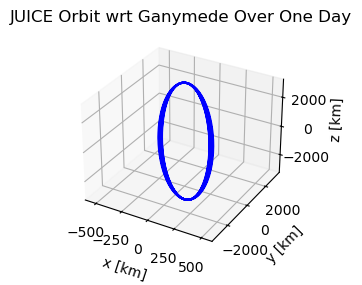

In [27]:
# Get simulation results over first propagation arc
simulation_results_first_arc = simulation_results[0]
propagated_state_first_arc = result2array(simulation_results_first_arc.state_history)
dependent_variables_first_arc = result2array(simulation_results_first_arc.dependent_variable_history)

fig = plt.figure()
# Plot trajectory of JUICE during first propagation arc
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(propagated_state_first_arc[:, 1]/1e3, propagated_state_first_arc[:, 2]/1e3, propagated_state_first_arc[:, 3]/1e3, color='blue')
ax1.set_xlabel('x [km]')
ax1.set_ylabel('y [km]')
ax1.set_zlabel('z [km]')
ax1.set_title('JUICE Orbit wrt Ganymede Over One Day')
ax1.grid()

If you recall, we had also chosen to save the latitude and longitude of JUICE on Ganymede along the propagation, as dependent variables.
We can now use that information to see the ground track of `JUICE` on Ganymede. In order to do this, we will use the `ganymede_map.jpg` file.

In [28]:
# Plot JUICE ground track during first propagation arc
ax2 = fig.add_subplot(122)
ganymede_map = '../propagation/ganymede_map.jpg'
ax2.imshow(plt.imread(ganymede_map), extent = [0, 360, -90, 90])

# Resolve 2pi ambiguity longitude
for k in range(len(dependent_variables_first_arc)):
    if dependent_variables_first_arc[k, 2] < 0:
        dependent_variables_first_arc[k, 2] = dependent_variables_first_arc[k, 2] + 2.0 * np.pi
ax2.plot(dependent_variables_first_arc[:, 2]*180/np.pi, dependent_variables_first_arc[:, 1]*180.0/np.pi, '.', markersize=2, color='blue')

ax2.set_xlabel('Longitude [deg]')
ax2.set_ylabel('Latitude [deg]')
ax2.set_xticks(np.arange(0, 361, 40))
ax2.set_yticks(np.arange(-90, 91, 30))
ax2.set_title('JUICE Ground Track Over One Day')

Text(0.5, 1.0, 'JUICE Ground Track Over One Day')

We can also visualize the **weighted partials** values as a function of estimated parameter and observation.

/var/folders/yj/2qwj1fqx3055rxkv0yk5dlpc0000gn/T/ipykernel_5818/1660120290.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(partials)), aspect='auto', interpolation='none')


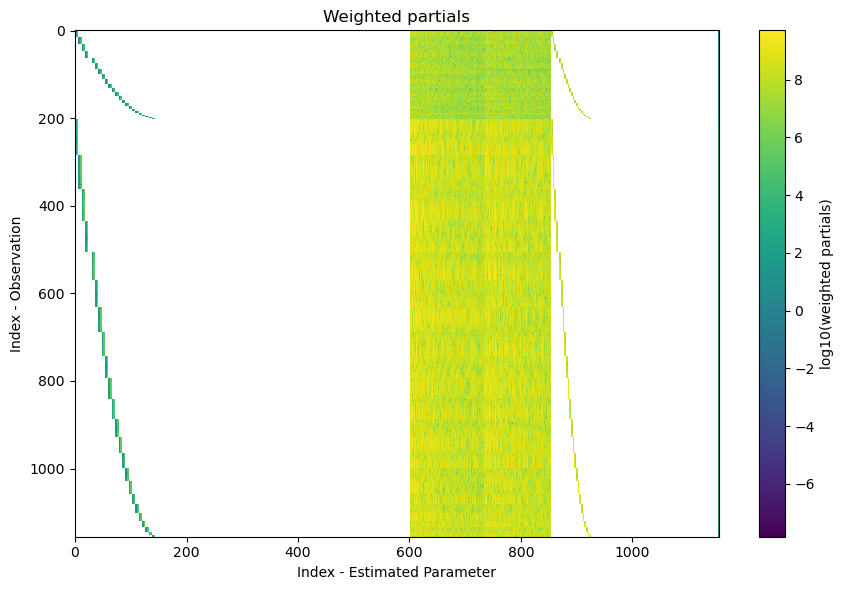

In [29]:
# Plot weighted partials
plt.figure(figsize=(9, 6))
plt.imshow(np.log10(np.abs(partials)), aspect='auto', interpolation='none')
cb = plt.colorbar()
cb.set_label('log10(weighted partials)')
plt.title("Weighted partials")
plt.ylabel("Index - Observation")
plt.xlabel("Index - Estimated Parameter")
plt.tight_layout()

# # Plot contribution of consider parameters to formal errors
# plt.figure()
# plt.plot(apriori_constraints, label='apriori constraints')
# plt.plot(formal_errors, label='nominal errors')
# plt.plot(formal_errors_with_consider_parameters, label='errors w/ consider parameters')
# plt.grid()
# plt.yscale("log")
# plt.ylabel('Formal errors')
# plt.xlabel('Index parameter [-]')
# plt.legend()
# plt.title('Effect consider parameters')

Let's plot the **correlation values** between the estimated parameters, too (this is similar at what we have already seen in the very first Delfi-C3 covariance example, where correlation results are also properly commented: https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/covariance_estimated_parameters.html).

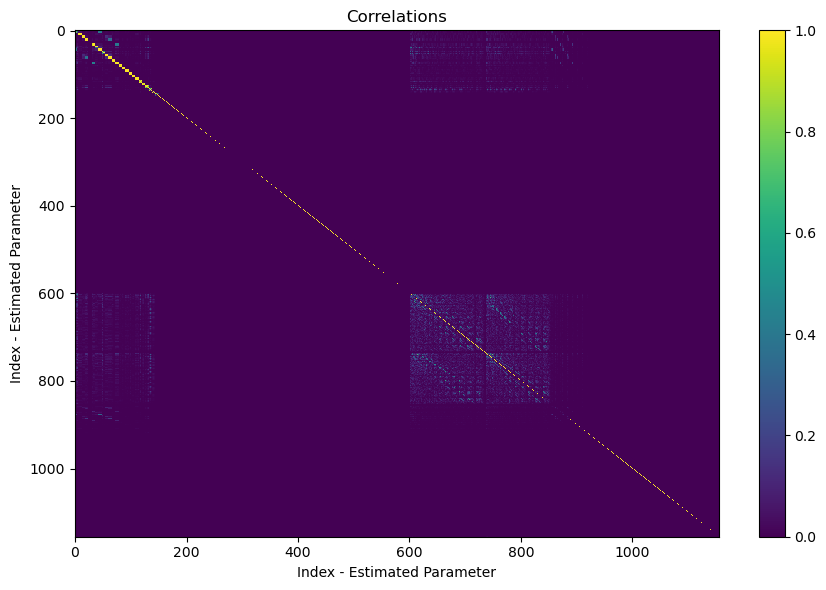

In [30]:
# Plot correlations (default)
plt.figure(figsize=(9, 6))
plt.imshow(np.abs(correlations), aspect='auto', interpolation='none')
plt.colorbar()
plt.title("Correlations")
plt.xlabel("Index - Estimated Parameter")
plt.ylabel("Index - Estimated Parameter")
plt.tight_layout()

# # Plot correlations (incl. contribution of consider parameters)
# plt.figure(figsize=(9, 6))
# plt.imshow(np.abs(correlations_with_consider_parameters), aspect='auto', interpolation='none')
# plt.colorbar()
# plt.title("Correlations w/ consider parameters")
# plt.xlabel("Index - Estimated Parameter")
# plt.ylabel("Index - Estimated Parameter")
# plt.tight_layout()

We can also plot the **doppler observations times** from the *Malargue* station, for the first arc.

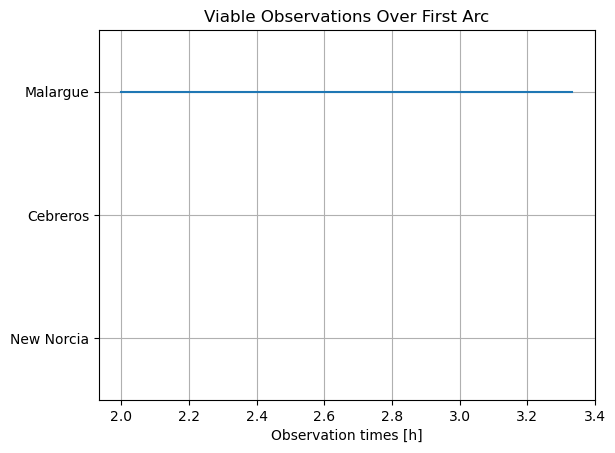

In [31]:
# Retrieve Doppler observation times for the first arc. For now only Malargue, but should eventually include all three ESTRACK stations
sorted_observations = simulated_observations.sorted_observation_sets
# doppler_obs_times_new_norcia_first_arc = [(t-start_gco)/3600.0 for t in sorted_observations[observation.n_way_averaged_doppler_type][0][0].observation_times if t <= start_gco+arc_duration]
# doppler_obs_times_cebreros_first_arc = [(t-start_gco)/3600.0 for t in sorted_observations[observation.n_way_averaged_doppler_type][1][0].observation_times if t <= start_gco+arc_duration]
doppler_obs_times_malargue_first_arc = [(t-start_gco)/3600.0 for t in sorted_observations[observation.n_way_averaged_doppler_type][0][0].observation_times if t <= start_gco+arc_duration]


# Plot observation times (for now only for Malargue, but designed to eventually include all three ESTRACK stations)
plt.figure()
# plt.plot(doppler_obs_times_new_norcia_first_arc, np.ones((len(doppler_obs_times_new_norcia_first_arc),1 )))
# plt.plot(doppler_obs_times_cebreros_first_arc, 2.0 * np.ones((len(doppler_obs_times_cebreros_first_arc),1 )))
plt.plot(doppler_obs_times_malargue_first_arc, 3.0 * np.ones((len(doppler_obs_times_malargue_first_arc),1 )))
plt.xlabel('Observation times [h]')
plt.ylabel('')
plt.yticks([1, 2, 3], ['New Norcia', 'Cebreros', 'Malargue'])
plt.ylim([0.5, 3.5])
plt.title('Viable Observations Over First Arc')
plt.grid()

Finally, we can plot the estimated **Root Mean Square of the Gravity Coefficients** and compare it to the (more conservative) Kaula's rule.

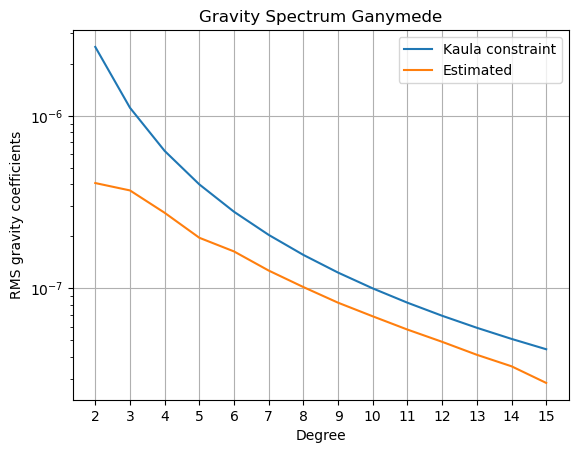

In [32]:
# Plot gravity field spectrum (a priori + formal errors)
# Extract a priori cosine and sine coefs
apriori_cosine_coefs = np.reciprocal(np.sqrt(inv_apriori.diagonal()))[indices_cosine_coef[0]:indices_cosine_coef[0]+indices_cosine_coef[1]]
apriori_sine_coefs = np.reciprocal(np.sqrt(inv_apriori.diagonal()))[indices_sine_coef[0]:indices_sine_coef[0]+indices_sine_coef[1]]

# Extract formal errors for Ganymede's cosine and sine coefficients
formal_errors_cosine_coefs = covariance_output.formal_errors[indices_cosine_coef[0]:indices_cosine_coef[0]+indices_cosine_coef[1]]
formal_errors_sine_coefs = covariance_output.formal_errors[indices_sine_coef[0]:indices_sine_coef[0]+indices_sine_coef[1]]

# Initialise empty vectors for gravity field coefficients' a priori constraints and errors
apriori_cosine_per_deg = np.zeros(max_deg_ganymede_gravity-1)
apriori_sine_per_deg = np.zeros(max_deg_ganymede_gravity-1)
formal_errors_cosine_per_deg = np.zeros(max_deg_ganymede_gravity-1)
formal_errors_sine_per_deg = np.zeros(max_deg_ganymede_gravity-1)

# Compute rms of a priori constraints and formal errors for gravity field coefficients
start_index_cosine_deg = 0
start_index_sine_deg = 0
for deg in range(2, max_deg_ganymede_gravity+1):

    # Cosine coefficients
    rms_apriori = 0
    rms_error = 0
    for j in range(deg+1):
        rms_apriori += getKaulaConstraint(kaula_constraint_multiplier, deg)**2
        rms_error += formal_errors_cosine_coefs[start_index_cosine_deg+j]**2
    start_index_cosine_deg += deg+1

    apriori_cosine_per_deg[deg-2] = np.sqrt(rms_apriori/(deg+1))
    formal_errors_cosine_per_deg[deg-2] = np.sqrt(rms_error/(deg+1))

    # Sine coefficients
    rms_apriori = 0
    rms_error = 0
    for j in range(deg):
        rms_apriori += getKaulaConstraint(kaula_constraint_multiplier, deg)
        rms_error += formal_errors_sine_coefs[start_index_sine_deg+j]**2
    start_index_sine_deg += deg

    apriori_sine_per_deg[deg-2] = np.sqrt(rms_apriori/deg)
    formal_errors_sine_per_deg[deg-2] = np.sqrt(rms_error/deg)


# Plot Ganymede's gravity spectrum
plt.figure()
plt.plot(apriori_cosine_per_deg, label='Kaula constraint')
plt.plot(formal_errors_cosine_per_deg, label='Estimated')
plt.grid()
plt.yscale("log")
plt.ylabel('RMS gravity coefficients')
plt.xlabel('Degree')
plt.xticks(np.arange(0, max_deg_ganymede_gravity-1, 1), np.arange(2, max_deg_ganymede_gravity+1, 1))
plt.title('Gravity Spectrum Ganymede')
plt.legend()

# Show all plots
plt.show()